In [1]:

import xarray as xr


ds_sat = xr.open_dataset('LGMR_data/LGMR_SAT_climo.nc')

import pandas as pd
df_pre = pd.read_csv(r"D:\VScode\Inso_LGMR\inso_data\pre.csv")
df_obl = pd.read_csv(r"D:\VScode\Inso_LGMR\inso_data\obl.csv")

df = pd.DataFrame({
    'Time': ds_sat['age'].values,
    'X': df_pre['pre'].values,
    'Y': ds_sat['sat'].isel(lat=80).isel(lon=0).values
})

ds_sat.info()

xarray.Dataset {
dimensions:
	lat = 96 ;
	lon = 144 ;
	age = 120 ;

variables:
	float32 lat(lat) ;
		lat:FillValue = 9.969209968386869e+36 ;
		lat:long_name = vector latitudes ;
		lat:units = degrees_north ;
	float32 lon(lon) ;
		lon:FillValue = 9.969209968386869e+36 ;
		lon:long_name = vector of longitudes ;
		lon:units = degrees_east ;
	float32 age(age) ;
		age:long_name = reconstruction bin mid-point (years BP) ;
	float32 sat(age, lat, lon) ;
		sat:FillValue = 9.969209968386869e+36 ;
		sat:long_name = ENSEMBLE MEAN (n = 500) mean annual temperature at reference height ;
		sat:units = degrees Celsius ;
	float32 sat_std(age, lat, lon) ;
		sat_std:FillValue = 9.969209968386869e+36 ;
		sat_std:long_name = ENSEMBLE STANDARD DEVIATION (n = 500) mean annual temperature at reference height ;
		sat_std:units = degrees Celsius ;

// global attributes:
}

d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv
d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


In [9]:
ds_sat

<xarray.Dataset>
Dimensions:  (lat: 96, lon: 144, age: 120)
Coordinates:
  * lat      (lat) float32 -90.0 -88.11 -86.21 -84.32 ... 84.32 86.21 88.11 90.0
  * lon      (lon) float32 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
  * age      (age) float32 100.0 300.0 500.0 ... 2.35e+04 2.37e+04 2.39e+04
Data variables:
    sat      (age, lat, lon) float32 ...
    sat_std  (age, lat, lon) float32 ...

d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison



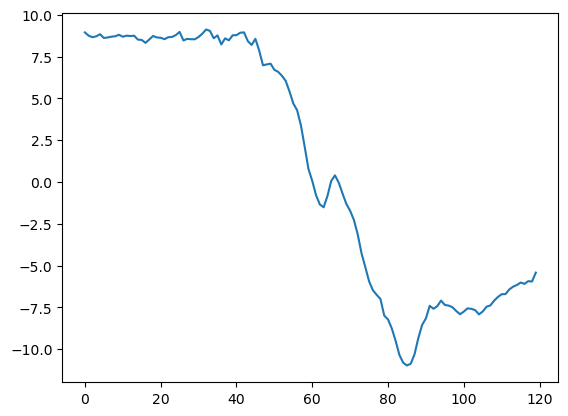

In [10]:
# plot any sat from the ds_sat

import matplotlib.pyplot as plt
import numpy as np

plt.plot(ds_sat['sat'].isel(lat=80).isel(lon=0).values)

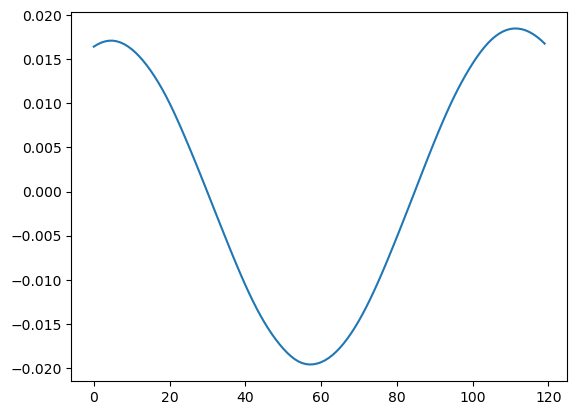

In [12]:
# plot df_pre
plt.plot(df_pre['pre'].values)

# print(df_pre['pre'].values)

In [2]:
import xarray as xr
import pandas as pd
import numpy as np
import random

import plotly.graph_objects as go
from plotly.subplots import make_subplots

from pyEDM import EmbedDimension

# Assume ds_sat and df_pre are already defined
# Grab coordinate sizes
nlat = ds_sat.sizes["lat"]
nlon = ds_sat.sizes["lon"]
ages = ds_sat["age"].values  # keep track of the ages

# ---------------------------------------------------------------------
# 2. Randomly select 10 (lat, lon) grid points
# ---------------------------------------------------------------------
all_pairs = [(ilat, ilon) for ilat in range(nlat) for ilon in range(nlon)]
random_pairs = random.sample(all_pairs, 10)  # pick 10 unique (ilat, ilon)

results_list = []  # will be a list of (ilat, ilon, E_axis, Tau_axis, RhoMatrix)

for idx, (ilat, ilon) in enumerate(random_pairs):
    # Extract local sat time series
    sat_ts = ds_sat["sat"].isel(lat=ilat, lon=ilon).values

    df_tmp = pd.DataFrame({
        "Time": ages,
        "pre": df_pre["pre"],  # predictor
        "sat": sat_ts          # target to predict
    })

    # We'll store a 2D array of shape (5,10) for E=1..5, tau=1..10
    RhoMatrix = np.zeros((5, 10))

    # For each tau in 1..10, call EmbedDimension once with maxE=5 and Tp=tau
    for tau in range(1, 11):
        edm_out = EmbedDimension(
            dataFrame=df_tmp,
            columns="sat",
            target="pre",
            maxE=5,          # We'll evaluate E=1..5
            tau=tau,
            Tp=5,
            lib="1 120",     # Entire time series, adapt if needed
            pred="1 120",
            showPlot=False,  # We'll handle plotting ourselves
        )

        for e_row in edm_out.itertuples():
            e_val = e_row.E     # 1..5
            rho_val = e_row.rho
            RhoMatrix[int(e_val - 1), int(tau - 1)] = rho_val

    # Axis values for plotting
    E_axis = np.arange(1, 6)     # E = 1..5
    Tau_axis = np.arange(1, 11)  # tau = 1..10

    # Save the result for this grid point
    results_list.append((ilat, ilon, E_axis, Tau_axis, RhoMatrix))

# ---------------------------------------------------------------------
# Compute global min and max for all RhoMatrix values
# ---------------------------------------------------------------------
global_min = min(np.min(RhoMatrix) for _, _, _, _, RhoMatrix in results_list)
global_max = max(np.max(RhoMatrix) for _, _, _, _, RhoMatrix in results_list)

# ---------------------------------------------------------------------
# 4. Make a 3D surface plot for each of the 10 results using Plotly subplots
# ---------------------------------------------------------------------

# Create subplot titles using true latitude and longitude values
subplot_titles = [
    f"lat={ds_sat['lat'].values[r[0]]:.2f}, lon={ds_sat['lon'].values[r[1]]:.2f}"
    for r in results_list
]

# Create a 2x5 grid of 3D subplots with adjusted spacing
fig = make_subplots(
    rows=2, cols=5,
    specs=[[{"type": "surface"}]*5, [{"type": "surface"}]*5],
    subplot_titles=subplot_titles,
    horizontal_spacing=0.03,  # reduce horizontal spacing
    vertical_spacing=0.1      # reduce vertical spacing
)

# Add each surface plot trace to its respective subplot
for i, (ilat, ilon, E_axis, Tau_axis, RhoMatrix) in enumerate(results_list):
    E_grid, Tau_grid = np.meshgrid(E_axis, Tau_axis, indexing='ij')
    row = (i // 5) + 1
    col = (i % 5) + 1

    # For a common colorbar, all surfaces use the same color range.
    # We enable the colorbar (showscale=True) only for the first trace.
    surf = go.Surface(
        x=E_grid,       # E dimension
        y=Tau_grid,     # tau dimension
        z=RhoMatrix,    # rho values
        colorscale="Viridis",
        cmin=global_min,
        cmax=global_max,
        showscale=True if i == 0 else False,
        # Customize the colorbar for the first subplot
        colorbar=dict(
            title="rho",
            titleside="right",
            x=1.02,  
            # adjust the shrink ratio to make the colorbar shorter
            len=0.3
        ) if i == 0 else None
    )

    fig.add_trace(surf, row=row, col=col)

# Update overall layout with adjusted margins for better label visibility
fig.update_layout(
    height=1600,
    width=2800,
    margin=dict(l=50, r=50, t=80, b=50),
)

# ---------------------------------------------------------------------
# 3. Adjust the viewing angle (camera) for each subplot
# ---------------------------------------------------------------------
# Loop over each subplot scene and set the camera view.
# Note: The first scene is named 'scene', and subsequent ones as 'scene2', 'scene3', etc.
for i in range(1, len(results_list)+1):
    scene_id = f'scene{i}' if i > 1 else 'scene'
    fig.layout[scene_id].update(
        xaxis_title="E",
        yaxis_title="tau",
        zaxis_title="rho",
        camera=dict(
            eye=dict(x=1, y=2, z=3)  
        )
    )

fig.show()


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv
d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv
d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv
d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv
d:\Users\User\an

In [ ]:
# fig.write_image("surface_plots.png", width=1400, height=800, scale=3)
fig.write_image("surface_plots.svg", width=1400, height=800)

In [2]:
import xarray as xr
import pandas as pd
import numpy as np
import random

import plotly.graph_objects as go
from plotly.subplots import make_subplots

from pyEDM import EmbedDimension

# Assume ds_sat and df_pre are already defined
# Grab coordinate sizes
nlat = ds_sat.sizes["lat"]
nlon = ds_sat.sizes["lon"]
ages = ds_sat["age"].values  # keep track of the ages

# ---------------------------------------------------------------------
# 2. Randomly select 10 (lat, lon) grid points
# ---------------------------------------------------------------------
all_pairs = [(ilat, ilon) for ilat in range(nlat) for ilon in range(nlon)]
random_pairs = random.sample(all_pairs, 10)  # pick 10 unique (ilat, ilon)

results_list = []  # will be a list of (ilat, ilon, E_axis, Tau_axis, RhoMatrix)

for idx, (ilat, ilon) in enumerate(random_pairs):
    # Extract local sat time series
    sat_ts = ds_sat["sat"].isel(lat=ilat, lon=ilon).values

    df_tmp = pd.DataFrame({
        "Time": ages,
        "pre": df_pre["pre"],  # predictor
        "sat": sat_ts          # target to predict
    })

    # We'll store a 2D array of shape (5,10) for E=1..5, tau=1..10
    RhoMatrix = np.zeros((5, 10))

    # For each tau in 1..10, call EmbedDimension once with maxE=5 and Tp=tau
    for tau in range(1, 11):
        edm_out = EmbedDimension(
            dataFrame=df_tmp,
            columns="sat",
            target="pre",
            maxE=5,          # We'll evaluate E=1..5
            tau=tau,
            Tp=5,
            lib="1 120",     # Entire time series, adapt if needed
            pred="1 120",
            showPlot=False,  # We'll handle plotting ourselves
        )

        for e_row in edm_out.itertuples():
            e_val = e_row.E     # 1..5
            rho_val = e_row.rho
            RhoMatrix[int(e_val - 1), int(tau - 1)] = rho_val

    # Axis values for plotting
    E_axis = np.arange(1, 6)     # E = 1..5
    Tau_axis = np.arange(1, 11)  # tau = 1..10

    # Save the result for this grid point
    results_list.append((ilat, ilon, E_axis, Tau_axis, RhoMatrix))

# ---------------------------------------------------------------------
# 4. Make a 3D surface plot for each of the 10 results using Plotly subplots
# ---------------------------------------------------------------------

# Create subplot titles using true latitude and longitude values
subplot_titles = [
    f"lat={ds_sat['lat'].values[r[0]]:.2f}, lon={ds_sat['lon'].values[r[1]]:.2f}"
    for r in results_list
]

# Create a 2x5 grid of 3D subplots with adjusted spacing
fig = make_subplots(
    rows=2, cols=5,
    specs=[[{"type": "surface"}]*5, [{"type": "surface"}]*5],
    subplot_titles=subplot_titles,
    horizontal_spacing=0.03,  # reduce horizontal spacing
    vertical_spacing=0.1      # reduce vertical spacing
)

# Add each surface plot trace to its respective subplot
for i, (ilat, ilon, E_axis, Tau_axis, RhoMatrix) in enumerate(results_list):
    E_grid, Tau_grid = np.meshgrid(E_axis, Tau_axis, indexing='ij')
    row = (i // 5) + 1
    col = (i % 5) + 1

    surf = go.Surface(
        x=E_grid,       # E dimension
        y=Tau_grid,     # tau dimension
        z=RhoMatrix,    # rho values
        colorscale="Viridis",
        showscale=False
    )


    fig.add_trace(surf, row=row, col=col)
       
    # set x ticks
    # fig.update_xaxes(title_text="E", row=row, col=col, tickmode="array", tickvals=[1, 2, 3, 4, 5])


# Update overall layout with adjusted margins for better label visibility
fig.update_layout(
    height=1600,
    width=2800,
    margin=dict(l=50, r=50, t=80, b=50),
    # title="3D Surface Plots with Adjusted Subplots and Viewing Angles"
)



# ---------------------------------------------------------------------
# 3. Adjust the viewing angle (camera) for each subplot
# ---------------------------------------------------------------------
# Loop over each subplot scene and set the camera view.
# Note: The first scene is named 'scene', and subsequent ones as 'scene2', 'scene3', etc.
for i in range(1, len(results_list)+1):
    scene_id = f'scene{i}' if i > 1 else 'scene'
    fig.layout[scene_id].update(
        xaxis_title="E",
        yaxis_title="tau",
        zaxis_title="rho",
        camera=dict(
            eye=dict(x=1, y=2, z=3)  
        )
    )

fig.show()


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv
d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv
d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv
d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv
d:\Users\User\an

d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison

d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison

d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison

d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison

d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning:

el

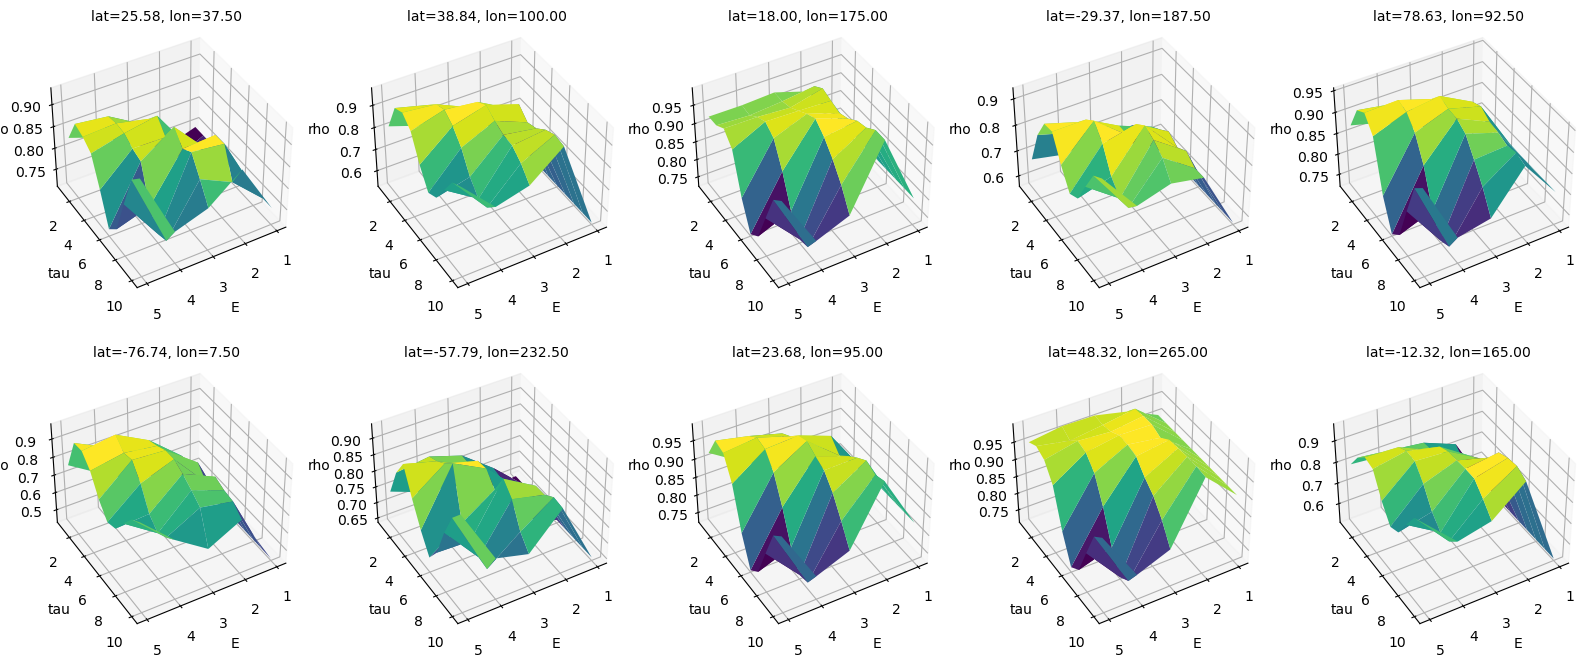

In [ ]:
import xarray as xr
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # required for 3D plotting
from pyEDM import EmbedDimension

# Assume ds_sat and df_pre are already defined
# Grab coordinate sizes and time variable
nlat = ds_sat.sizes["lat"]
nlon = ds_sat.sizes["lon"]
ages = ds_sat["age"].values  # time coordinate

# ---------------------------------------------------------------------
# 1. Randomly select 10 (lat, lon) grid points
# ---------------------------------------------------------------------
all_pairs = [(ilat, ilon) for ilat in range(nlat) for ilon in range(nlon)]
random_pairs = random.sample(all_pairs, 10)  # pick 10 unique (ilat, ilon)

results_list = []  # will store (ilat, ilon, E_axis, Tau_axis, RhoMatrix)

for idx, (ilat, ilon) in enumerate(random_pairs):
    # Extract local satellite time series
    sat_ts = ds_sat["sat"].isel(lat=ilat, lon=ilon).values

    df_tmp = pd.DataFrame({
        "Time": ages,
        "pre": df_pre["pre"],  # predictor
        "sat": sat_ts          # target to predict
    })

    # Prepare a 2D array of shape (5, 10) for E=1..5, tau=1..10
    RhoMatrix = np.zeros((5, 10))

    # For each tau in 1..10, run EmbedDimension with maxE=5 and Tp=5
    for tau in range(1, 11):
        edm_out = EmbedDimension(
            dataFrame=df_tmp,
            columns="sat",
            target="pre",
            maxE=5,          # evaluate E = 1..5
            tau=tau,
            Tp=5,
            lib="1 120",     # adapt library range if needed
            pred="1 120",
            showPlot=False,  # plotting is done via Matplotlib
        )

        for e_row in edm_out.itertuples():
            e_val = e_row.E  # E value (1..5)
            rho_val = e_row.rho
            RhoMatrix[int(e_val - 1), int(tau - 1)] = rho_val

    # Define axis values for plotting
    E_axis = np.arange(1, 6)     # E = 1..5
    Tau_axis = np.arange(1, 11)  # tau = 1..10

    # Save result along with grid point indices
    results_list.append((ilat, ilon, E_axis, Tau_axis, RhoMatrix))

# ---------------------------------------------------------------------
# 2. Create a stationary figure with 2 rows x 5 columns of 3D subplots
# ---------------------------------------------------------------------
fig = plt.figure(figsize=(20, 8))

for i, (ilat, ilon, E_axis, Tau_axis, RhoMatrix) in enumerate(results_list):
    ax = fig.add_subplot(2, 5, i+1, projection='3d')
    # Create meshgrid for surface plotting
    E_grid, Tau_grid = np.meshgrid(E_axis, Tau_axis, indexing='ij')
    surf = ax.plot_surface(E_grid, Tau_grid, RhoMatrix, cmap='viridis')
    
    # Set subplot title with true latitude and longitude values
    lat_val = ds_sat['lat'].values[ilat]
    lon_val = ds_sat['lon'].values[ilon]
    ax.set_title(f"lat={lat_val:.2f}, lon={lon_val:.2f}", fontsize=10)

    # adjust the viewing angle
    # ax.view_init(elev=20, azim=45)
    
    # Label the axes
    ax.set_xlabel("E")
    ax.set_ylabel("tau")
    ax.set_zlabel("rho")
    
    # -----------------------------------------------------------------
    # 3. Change the viewing angle (camera) of the subplot:
    # Use view_init(elev, azim) to set elevation and azimuth angles.
    # Adjust these values to your preferred perspective.
    # -----------------------------------------------------------------
    ax.view_init(elev=40, azim=60)

# Adjust layout to ensure axis labels are not overlapped
# plt.tight_layout()
plt.show()


In [ ]:
import xarray as xr
import pandas as pd
import numpy as np
import random

import plotly.graph_objects as go
from plotly.subplots import make_subplots

from pyEDM import EmbedDimension


# assert ds_sat.sizes["age"] == len(df_pre), (
#     "ds_sat age dimension must match length of precession time series."
# )


# Grab coordinate sizes
nlat = ds_sat.sizes["lat"]
nlon = ds_sat.sizes["lon"]
ages = ds_sat["age"].values  # not strictly needed but good to keep track

# ---------------------------------------------------------------------
# 2. Randomly select 10 (lat, lon) grid points
# ---------------------------------------------------------------------
all_pairs = [(ilat, ilon) for ilat in range(nlat) for ilon in range(nlon)]
random_pairs = random.sample(all_pairs, 10)  # pick 10 unique (ilat, ilon)



results_list = []  # will be a list of (ilat, ilon, Evals, Tauvals, RhoMatrix)

for idx, (ilat, ilon) in enumerate(random_pairs):
    # Extract local sat time series
    sat_ts = ds_sat["sat"].isel(lat=ilat, lon=ilon).values

    df_tmp = pd.DataFrame({
        "Time": ages,
        "pre": df_pre["pre"],  # predictor
        "sat": sat_ts          # target to predict
    })

    # We'll store a 2D array of shape (5,10) for E=1..5, tau=1..10
    # Accessed as RhoMatrix[E-1, tau-1].
    RhoMatrix = np.zeros((5, 10))

    # For each tau in 1..10, call EmbedDimension once with maxE=5 and Tp=tau
    for tau in range(1, 11):
        edm_out = EmbedDimension(
            dataFrame=df_tmp,
            columns="sat",
            target="pre",
            maxE=5,          # We'll evaluate E=1..5
            tau=tau,
            Tp=0,
            lib="1 120",     # Entire time series, adapt if needed
            pred="1 120",
            showPlot=False,  # We'll handle plotting ourselves
            # If you want to speed up or parallelize, you can set numThreads or numProcess
        )

        for e_row in edm_out.itertuples():
            e_val = e_row.E     # 1..5
            # print(e_val)
            rho_val = e_row.rho
            RhoMatrix[int(e_val - 1), int(tau - 1)] = rho_val

    # We'll store the axis values for plotting (note: we want these in 2D for a surface plot).
    E_axis = np.arange(1, 6)     # 1..5
    Tau_axis = np.arange(1, 11)  # 1..10

    # Save the result for this grid point
    results_list.append((ilat, ilon, E_axis, Tau_axis, RhoMatrix))

# ---------------------------------------------------------------------
# 4. Make a 3D surface plot for each of the 10 results
#    using Plotly subplots
# ---------------------------------------------------------------------

# We'll do 2 rows, 5 columns of 3D subplots
fig = make_subplots(
    rows=2, cols=5,
    specs=[
        [{"type": "surface"}]*5,
        [{"type": "surface"}]*5
    ],
    subplot_titles=[f"Point {i+1}: (lat={r[0]}, lon={r[1]})" for i, r in enumerate(results_list)]
)

for i, (ilat, ilon, E_axis, Tau_axis, RhoMatrix) in enumerate(results_list):

    E_grid, Tau_grid = np.meshgrid(E_axis, Tau_axis, indexing='ij')

    row = (i // 5) + 1
    col = (i % 5) + 1

    # Create the surface trace
    surf = go.Surface(
        x=E_grid,       # E dimension
        y=Tau_grid,     # tau dimension
        z=RhoMatrix,    # rho
        colorscale="Viridis",   # or any Plotly colormap you like
        showscale=False         # hide colorbar in subplots for neatness
    )
    fig.add_trace(surf, row=row, col=col)

# Update overall layout
fig.update_layout(
    height=800, width=1400,
    title="",
    scene=dict(
        xaxis_title="E",
        yaxis_title="tau",
        zaxis_title="rho"
    ),
    # If you prefer separate axis labels per subplot, you can set them individually
    # with fig.update_xaxes(..., row=?, col=?)
)

fig.show()


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison

d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison

d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison

d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison

d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning:

el